In [21]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import pandas as pd
import Scripts.airfoil as af
import Scripts.fishUtilities as fu
import Scripts.fishFits as ff
import Scripts.surfaceAreaEstimators as sea
import Scripts.volumeEstimators as ve
import Scripts.cotEstimators as cot

from pathlib import Path
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [22]:
def power_law(xData, a, b):
        return a * xData ** b

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[1, 1])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [23]:
imagePath = r'./Pictures'
specimen = r'scannedSalmon'
figurePath = r'./Figures'

In [24]:
imagePathSide = fu.get_image_files(imagePath, specimen + 'SideNF.png')
imagePathSideFull = fu.get_image_files(imagePath, specimen + 'Side.png')

# import images
imageSide = cv2.imread(imagePathSide[0].as_posix())
imageSideFull = cv2.imread(imagePathSideFull[0].as_posix())


imagePathTop = fu.get_image_files(imagePath, specimen + 'TopNF.png')
imagePathTopFull = fu.get_image_files(imagePath, specimen + 'Top.png')

if(len(imagePathTopFull) == 0):
    imagePathTopFull = imagePathTop


# import images
imageTop = cv2.imread(imagePathTop[0].as_posix())
imageTopFull = cv2.imread(imagePathTopFull[0].as_posix())

In [25]:
# Split work depending on input images
def process_top(imageList):
    # make a copy of the image
    topImage = imageList[0].copy()
    if(len(imageList) < 2):
        topImageFull = imageList[0].copy()
    else:
        topImageFull = imageList[1].copy()
    # get contours
    cntsTop, hullTop = fu.get_contours(topImage)
    cntsTopFull, hullTopFull = fu.get_contours(topImageFull)
    
    # Find the area ratio of fins and no fins
    areaTopFull = cv2.contourArea(cntsTopFull)
    areaTopNF = cv2.contourArea(cntsTop)
    areaRatioTop = (1-np.abs(areaTopNF/areaTopFull))

    # split the hull into top and bottom
    (cxTop, cyTop), topHullTop, bottomHullTop = fu.split_by_centroid_top(topImage.shape, cntsTop)
    (cxTopFull, cyTopFull), topHullTopFull, bottomHullTopFull = fu.split_by_centroid_top(topImageFull.shape, cntsTopFull)

    # scale contour data
    areaTop, tHullTop, bHullTop = fu.scale_data_top(topHullTop, bottomHullTop)
    areaTopFull, tHullTopFull, bHullTopFull = fu.scale_data_top(topHullTopFull, bottomHullTopFull)
    
    # get min and max points
    maxPointsTop, minPointsTop = fu.get_min_max(tHullTop, bHullTop)
    
    # fit data
    topPolyArea, topFitTop, bottomFitTop = ff.fit_top_contours_poly(tHullTop, bHullTop, 6)
    nacaArea, m, thickness, d0, xu, yu, xl, yl = ff.fit_top_contours(areaTop, np.mean([minPointsTop[0],maxPointsTop[0]]), np.abs(minPointsTop[1])+maxPointsTop[1], (tHullTop[1,-5]+np.abs(bHullTop[1,-5]))/2.0)
    
    return (areaRatioTop, [cntsTop, cntsTopFull], [maxPointsTop, minPointsTop],
            [topFitTop, bottomFitTop], [m, thickness, d0], [tHullTop, bHullTop])

In [26]:
def process_side(imageList):
    # make a copy of the image
    sideImage = imageList[0].copy()
    sideImageFull = imageList[1].copy()

    # get contours
    cntsSide, hullSide = fu.get_contours(sideImage)
    cntsSideFull, hullSideFull = fu.get_contours(sideImageFull)
    
    # Find the area ratio of fins and no fins
    areaSideFull = cv2.contourArea(cntsSideFull)
    areaSideNF = cv2.contourArea(cntsSide)
    areaRatioSide = (1-np.abs(areaSideNF/areaSideFull))
    
    (cxSide, cySide), areaSideNF, topHullSide, bottomHullSide = fu.split_by_centroid_side(sideImage.shape, cntsSide)
    (cxSideFull, cySideFull), areaSideFull, topHullSideFull, bottomHullSideFull = fu.split_by_centroid_side(sideImageFull.shape, cntsSideFull)

    # scale contour data
    scaleFactorSide, tHullSide, bHullSide = fu.scale_data(topHullSide, bottomHullSide)
    scaleFactorSideFull, tHullSideFull, bHullSideFull = fu.scale_data(topHullSideFull, bottomHullSideFull)
    
    # get min and max points
    maxPointsSide, minPointsSide = fu.get_min_max(tHullSide, bHullSide)
    
    #fit data
    topFitSide, bottomFitSide = ff.fit_side_contours(tHullSide, bHullSide, 6)
    
    return (areaRatioSide, [cntsSide, cntsSideFull], [maxPointsSide, minPointsSide], [topFitSide, bottomFitSide], [tHullSide, bHullSide])

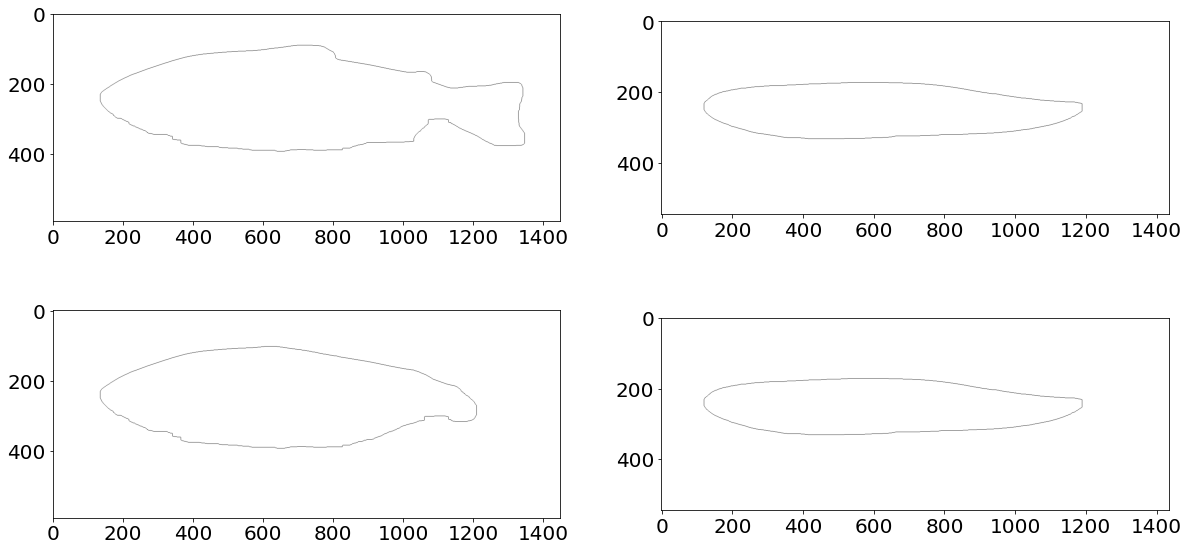

In [27]:
sideArea, sideContours, sidePoints, sideFits, sideHull = process_side([imageSide, imageSideFull])
cntsSideFull = sideContours[1]
cntsSide = sideContours[0]

topArea, topContours, topPoints, topPolyFits, nacaFits, topHull = process_top([imageTop])
cntsTopFull = topContours[1]
cntsTop = topContours[0]

sideMask = np.zeros(imageSide.shape, dtype=np.uint8)
cv2.drawContours(sideMask, [cntsSideFull], -1, (255, 255, 255), 1)
sideMask = cv2.bitwise_not(sideMask)

sideMaskNF = np.zeros(imageSide.shape, dtype=np.uint8)
cv2.drawContours(sideMaskNF, [cntsSide], -1, (255, 255, 255), 1)
sideMaskNF = cv2.bitwise_not(sideMaskNF)

topMask = np.zeros(imageTop.shape, dtype=np.uint8)
cv2.drawContours(topMask, [cntsTopFull], -1, (255, 255, 255), 1)
topMask = cv2.bitwise_not(topMask)

topMaskNF = np.zeros(imageTop.shape, dtype=np.uint8)
cv2.drawContours(topMaskNF, [cntsTop], -1, (255, 255, 255), 1)
topMaskNF = cv2.bitwise_not(topMaskNF)

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
ax1.imshow(sideMask)
ax2.imshow(topMask)
ax3.imshow(sideMaskNF)
ax4.imshow(topMaskNF)

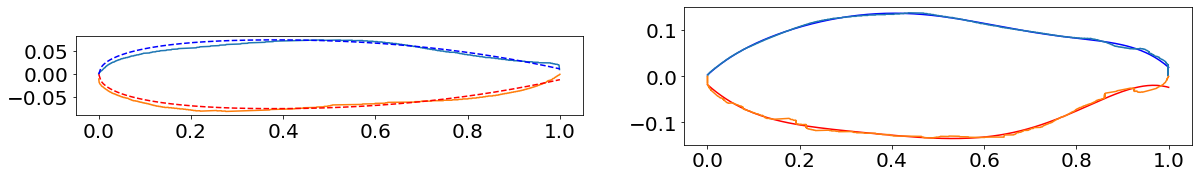

In [28]:
dx = np.linspace(0, 1.0, 200)
#nacaFits = [0.3973, 0.16, 0.01]
m = nacaFits[0]
thickness = nacaFits[1]
d0 = nacaFits[2]

topPolySide = np.poly1d(sideFits[0])
bottomPolySide = np.poly1d(sideFits[1])
topPolyTop = np.poly1d(topPolyFits[0])
bottomPolyTop = np.poly1d(topPolyFits[1])

X, Y = af.naca4_modified(dx, m, thickness, 1.0, d0)
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(topHull[0][0], topHull[0][1])
ax1.plot(topHull[1][0], topHull[1][1])
ax1.plot(X[0], Y[0], 'b--')
ax1.plot(X[1], Y[1], 'r--')
ax1.set_aspect('equal')
ax2.plot(dx, topPolySide(dx), 'b')
ax2.plot(dx, bottomPolySide(dx), 'r')
ax2.plot(sideHull[0][0], sideHull[0][1])
ax2.plot(sideHull[1][0], sideHull[1][1])
ax2.set_aspect('equal')

In [29]:
scalingData = r'blenderSalmonScaling.xlsx'

scaleDF = pd.read_excel(scalingData)
scaledLength = scaleDF['Length'].values
scaledArea = scaleDF['Area'].values
scaledVolume = scaleDF['Volume'].values

# convert from cm to meters
# area in m^2 and volume in m^3
scaledArea = scaledArea / 100**2
scaledVolume = scaledVolume / 100**3

density = 1025
mass = scaledVolume * density

In [30]:
sArea = np.zeros(len(scaledLength))
esMethod = np.zeros(len(scaledLength))
pdMethod = np.zeros(len(scaledLength))
eaMethod = np.zeros(len(scaledLength))
volume = np.zeros(len(scaledLength))
D_calc = np.zeros(len(scaledLength))
Sr_calc = np.zeros(len(scaledLength))

for idx, length in enumerate(scaledLength):
    sArea[idx], D_calc[idx] = sea.determine_surface_area(1, 2, 0, length*0.95, sideFits[0], sideFits[1], nacaFits, nacaFits)
    Sr_calc[idx] = length/D_calc[idx]
    volume[idx], height, width = ve.determine_volume(1, 2, 0, length*0.90, sideFits[0], sideFits[1], nacaFits, nacaFits)
    mass_calc = volume[idx]*density
    
    _, esMethod[idx], _ = sea.equivalentSpheroid(length, mass[idx], density)
    eaMethod[idx] = sea.ellipsoidApproximation(length*0.95, (np.abs(topPoints[0][1]) + np.abs(topPoints[1][1]))*length, (np.abs(sidePoints[0][1]) + np.abs(sidePoints[1][1]))*length)
    pdMethod[idx] = sea.partitionDisc(length*0.95, sideFits[0], sideFits[1], topPolyFits[0], topPolyFits[1])

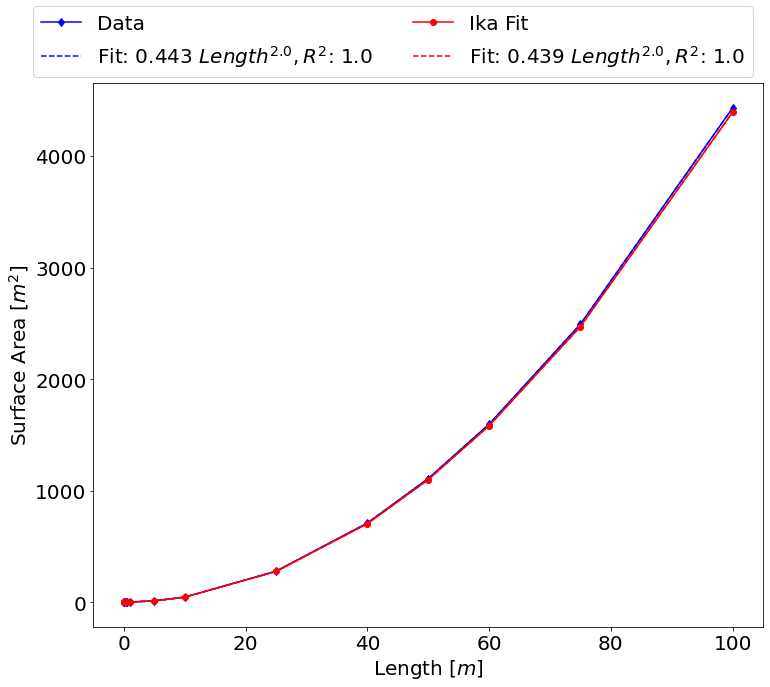

In [31]:
plt.rcParams.update({'font.size': 20})

#sArea = sArea + (sArea * sideArea)

popt_scaledSA, r_sq_scaledSA = fit_data(scaledLength, scaledArea)
popt_blender, r_sq_blender = fit_data(scaledLength, sArea)
popt_esMethod, r_sq_esMethod = fit_data(scaledLength, esMethod)
popt_eaMethod, r_sq_eaMethod = fit_data(scaledLength, eaMethod)
popt_pdMethod, r_sq_pdMethod = fit_data(scaledLength, pdMethod)

fig1, ax1 = plt.subplots(figsize=((12, 10)))
ax1.plot(scaledLength, scaledArea, 'bd-', label='Data')
ax1.plot(scaledLength, power_law(scaledLength, *popt_scaledSA), 'b--', label="Fit: " + str(np.round(popt_scaledSA[0], 3)) + " $Length^{" + str(np.round(popt_scaledSA[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_scaledSA, 2)))
ax1.plot(scaledLength, sArea, 'ro-', label = 'Ika Fit')
ax1.plot(scaledLength, power_law(scaledLength, *popt_blender), 'r--', label="Fit: " + str(np.round(popt_blender[0], 3)) + " $Length^{" + str(np.round(popt_blender[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_blender, 2)))
ax1.set_ylabel('Surface Area $[m^2]$')
ax1.set_xlabel('Length $[m]$')
ax1.legend(loc='best', ncol=2, bbox_to_anchor=((1.0, 1.16)))
#fig1.savefig(Path(figurePath).joinpath('Blender_SA_validation.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

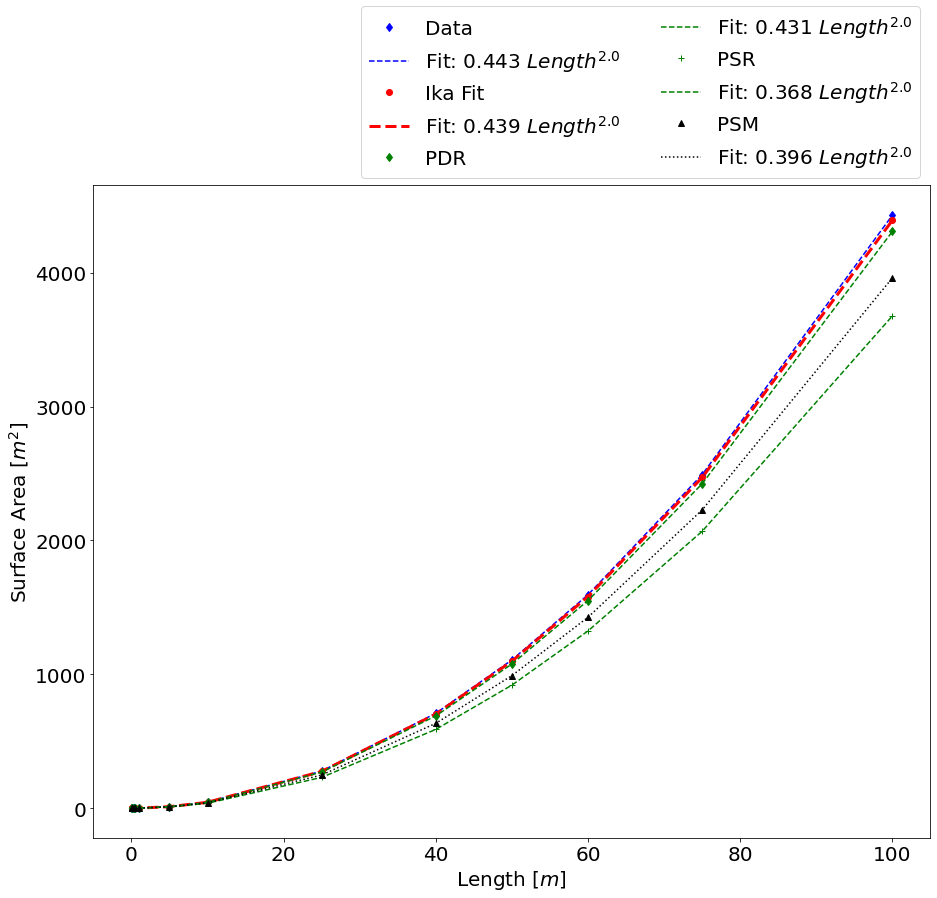

In [32]:
fig2, ax2 = plt.subplots(figsize=((15, 12)))
ax2.plot(scaledLength, scaledArea, 'bd', label='Data')
ax2.plot(scaledLength, power_law(scaledLength, *popt_scaledSA), 'b--', label="Fit: " + str(np.round(popt_scaledSA[0], 3)) + " $Length^{" + str(np.round(popt_scaledSA[1], 3)) + '}$')
ax2.plot(scaledLength, sArea, 'ro', label = 'Ika Fit')
ax2.plot(scaledLength, power_law(scaledLength, *popt_blender), 'r--', label="Fit: " + str(np.round(popt_blender[0], 3)) + " $Length^{" + str(np.round(popt_blender[1], 3)) + '}$', linewidth=3)
ax2.plot(scaledLength, pdMethod, 'gd', label = 'PDR')
ax2.plot(scaledLength, power_law(scaledLength, *popt_pdMethod), 'g--', label="Fit: " + str(np.round(popt_pdMethod[0], 3)) + " $Length^{" + str(np.round(popt_pdMethod[1], 3)) + '}$')
ax2.plot(scaledLength, eaMethod, 'g+', label = 'PSR')
ax2.plot(scaledLength, power_law(scaledLength, *popt_eaMethod), 'g--', label="Fit: " + str(np.round(popt_eaMethod[0], 3)) + " $Length^{" + str(np.round(popt_eaMethod[1], 3)) + '}$')
ax2.plot(scaledLength, esMethod, 'k^', label = 'PSM')
ax2.plot(scaledLength, power_law(scaledLength, *popt_esMethod), 'k:', label="Fit: " + str(np.round(popt_esMethod[0], 3)) + " $Length^{" + str(np.round(popt_esMethod[1], 3)) + '}$')
ax2.set_ylabel('Surface Area $[m^2]$')
ax2.set_xlabel('Length $[m]$')
ax2.legend(loc='best', ncol = 2, bbox_to_anchor=(1.0, 1.29))
#fig2.savefig(Path(figurePath).joinpath('Blender_all_comparison.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

In [33]:
error_ika = [np.sqrt(np.sum(np.abs(sArea - scaledArea)**2)/len(scaledLength)), np.sum(np.abs(sArea - scaledArea))/len(scaledArea)]
error_pd = [np.sqrt(np.sum(np.abs(pdMethod - scaledArea)**2)/len(scaledLength)), np.sum(np.abs(pdMethod - scaledArea))/len(scaledArea)]
error_ea = [np.sqrt(np.sum(np.abs(eaMethod - scaledArea)**2)/len(scaledLength)), np.sum(np.abs(eaMethod - scaledArea))/len(scaledArea)]
error_es = [np.sqrt(np.sum(np.abs(esMethod - scaledArea)**2)/len(scaledLength)), np.sum(np.abs(esMethod - scaledArea))/len(scaledArea)]

print(error_ika, error_pd, error_ea, error_es)

[12.253683511969898, 6.142404839973792] [39.00840133464735, 19.553076292236923] [241.12910337034447, 120.86508941046121] [150.09571347985064, 75.23478148081132]


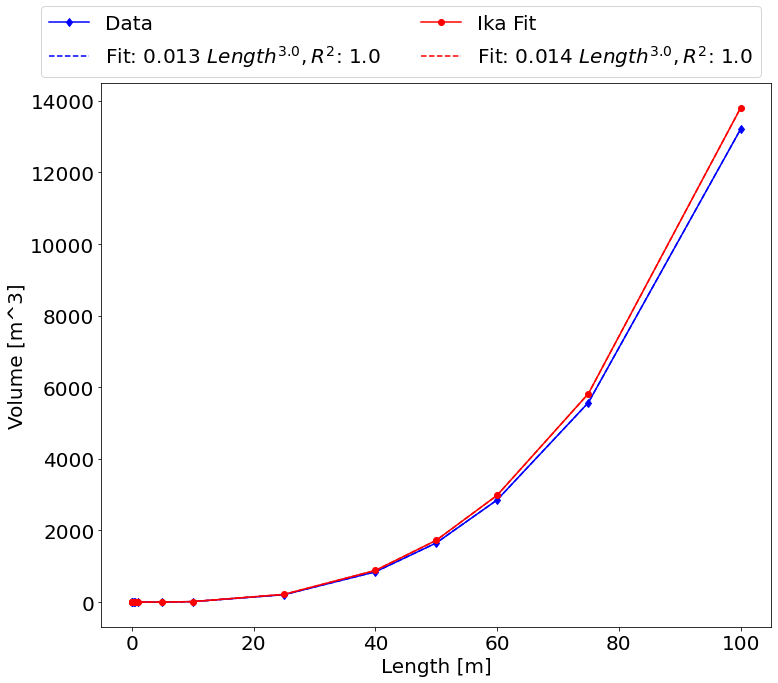

In [34]:
popt_scaledVol, r_sq_scaledVol = fit_data(scaledLength, scaledVolume)
popt_blenderVol, r_sq_blenderVol = fit_data(scaledLength, volume)


fig3, ax3 = plt.subplots(figsize=((12, 10)))
ax3.plot(scaledLength, scaledVolume, 'bd-', label='Data')
ax3.plot(scaledLength, power_law(scaledLength, *popt_scaledVol), 'b--', label="Fit: " + str(np.round(popt_scaledVol[0], 3)) + " $Length^{" + str(np.round(popt_scaledVol[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_scaledVol, 2)))
ax3.plot(scaledLength, volume, 'ro-', label = 'Ika Fit')
ax3.plot(scaledLength, power_law(scaledLength, *popt_blenderVol), 'r--', label="Fit: " + str(np.round(popt_blenderVol[0], 3)) + " $Length^{" + str(np.round(popt_blenderVol[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_blenderVol, 2)))
ax3.set_ylabel('Volume [m^3]')
ax3.set_xlabel('Length [m]')
ax3.legend(loc='best', ncol=2, bbox_to_anchor=((1.0, 1.16)))
#fig3.savefig(Path(figurePath).joinpath("Blender_volume_validation.pdf"), facecolor='w', bbox_inches='tight', dpi=300)

Text(40, 200, '2')

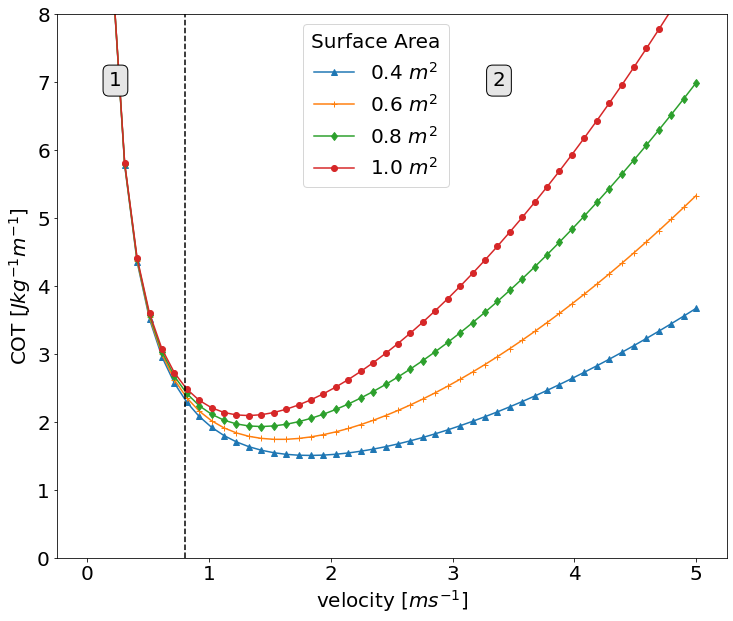

In [93]:
velocity = np.linspace(0.001, 5, 50)
kinVisc = 1.19*10**(-6)
efficiency = 0.5

marker_style = ['^-', '+-', 'd-', 'o-' ]

inf_area = np.linspace(0.4, 1, 4)

fig4, ax4 = plt.subplots(figsize=((12, 10)))

for idx, area in enumerate(inf_area):
    length = 1.0
    area_calc, D_calc = sea.determine_surface_area(1, 2, 0, length*0.95, sideFits[0], sideFits[1], nacaFits, nacaFits)
    Sr_calc = length/D_calc
    volume_calc, height, width = ve.determine_volume(1, 2, 0, length*0.90, sideFits[0], sideFits[1], nacaFits, nacaFits)
    mass_calc = volume_calc*density

    cot_area = np.divide((25 + cot.ITTC_pp(Sr_calc, area, length, mass_calc, efficiency,
                                           kinVisc, density, velocity)), (mass_calc * velocity))
    
    ax4.plot(velocity, cot_area, marker_style[idx], label=str(np.round(area, 3)) + ' $m^2$')

ax4.plot([0.8, 0.8], [0, 2000], 'k--')
ax4.set_ylabel('COT $[J kg^{-1} m^{-1}]$')
ax4.set_xlabel('velocity $[ms^{-1}]$')
ax4.set_ylim([0, 8])
ax4.legend(title='Surface Area', bbox_to_anchor=(0.6, 1.0))

ax4.annotate(
    '1',
    xy=(1., 4), xycoords='data',
    xytext=(-100, 200), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.9"))
ax4.annotate(
    '2',
    xy=(3., 4), xycoords='data',
    xytext=(40, 200), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.9"))
    
#fig4.savefig(Path(figurePath).joinpath('Area_influence.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

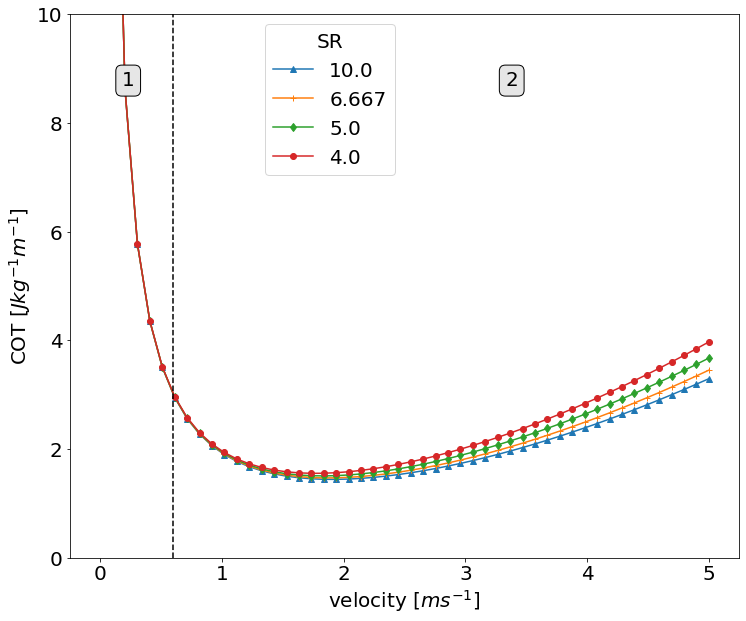

In [95]:
fig5, ax5 = plt.subplots(figsize=((12, 10)))

inf_Dcalc = np.linspace(0.1, 0.25, 4)

for idx, dCalc in enumerate(inf_Dcalc):
    length = 1.0
    area_calc, D_calc = sea.determine_surface_area(1, 2, 0, length*0.95, sideFits[0], sideFits[1], nacaFits, nacaFits)
    Sr_calc = length/dCalc
    volume_calc, height, width = ve.determine_volume(1, 2, 0, length*0.90, sideFits[0], sideFits[1], nacaFits, nacaFits)
    mass_calc = volume_calc*density

    cot_area = np.divide((25 + cot.ITTC_pp(Sr_calc, area_calc, length, mass_calc, efficiency,
                                           kinVisc, density, velocity)), (mass_calc * velocity))
    
    ax5.plot(velocity, cot_area,  marker_style[idx], label=str(np.round(Sr_calc, 3)))

ax5.annotate(
    '1',
    xy=(1., 5), xycoords='data',
    xytext=(-100, 200), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.9"))
ax5.annotate(
    '2',
    xy=(3., 5), xycoords='data',
    xytext=(40, 200), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.9"))

ax5.plot([0.6, 0.6], [0, 2000], 'k--')
ax5.set_ylabel('COT $[J kg^{-1} m^{-1}]$')
ax5.set_xlabel('velocity $[ms^{-1}]$')
ax5.set_ylim([0, 10])
ax5.legend(title='SR', bbox_to_anchor=(0.5, 1.0))
#fig5.savefig(Path(figurePath).joinpath('SR_influence.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

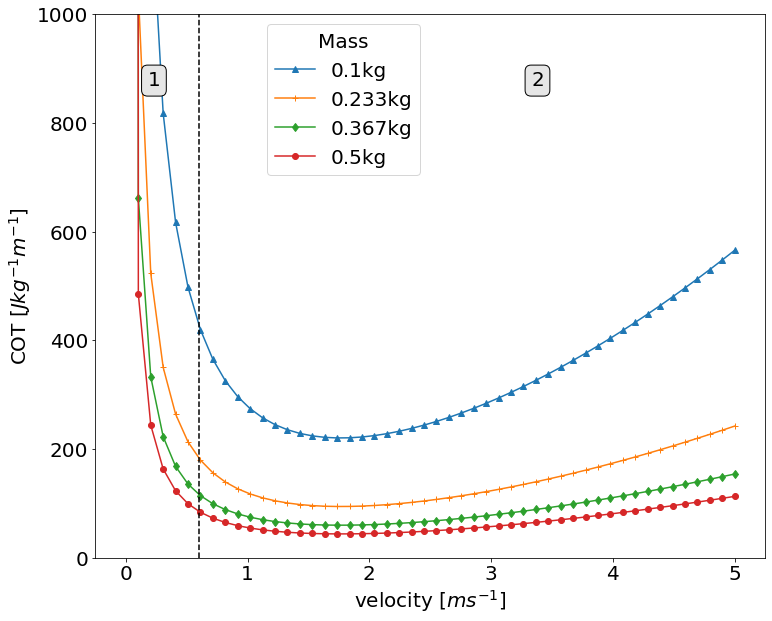

In [96]:
fig6, ax6 = plt.subplots(figsize=((12, 10)))

inf_mass = np.linspace(0.1, 0.5, 4)

for idx, mass in enumerate(inf_mass):
    length = 1.0
    area_calc, D_calc = sea.determine_surface_area(1, 2, 0, length*0.95, sideFits[0], sideFits[1], nacaFits, nacaFits)
    Sr_calc = length/D_calc
    volume_calc, height, width = ve.determine_volume(1, 2, 0, length*0.90, sideFits[0], sideFits[1], nacaFits, nacaFits)
    mass_calc = volume_calc*density

    cot_area = np.divide((25 + cot.ITTC_pp(Sr_calc, area_calc, length, mass, efficiency,
                                           kinVisc, density, velocity)), (mass * velocity))
    
    ax6.plot(velocity, cot_area, marker_style[idx], label=str(np.round(mass, 3)) + 'kg')

ax6.annotate(
    '1',
    xy=(1., 500), xycoords='data',
    xytext=(-100, 200), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.9"))
ax6.annotate(
    '2',
    xy=(3., 500), xycoords='data',
    xytext=(40, 200), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.9"))

ax6.plot([0.6, 0.6], [0, 2000], 'k--')
ax6.set_ylabel('COT $[J kg^{-1} m^{-1}]$')
ax6.set_xlabel('velocity $[ms^{-1}]$')
ax6.set_ylim([0, 1000])
ax6.legend(title='Mass', bbox_to_anchor=(0.5, 1.0))
#fig6.savefig(Path(figurePath).joinpath('mass_influence.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

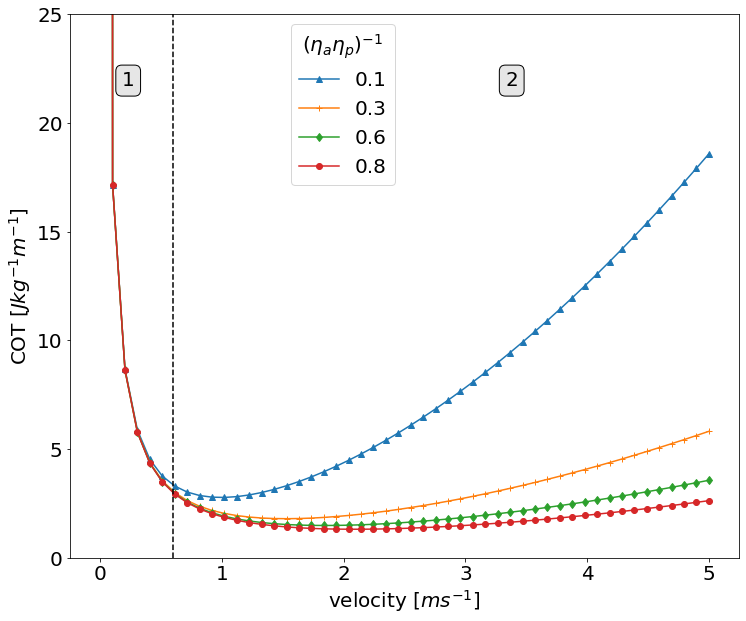

In [99]:
fig7, ax7 = plt.subplots(figsize=((12, 10)))

inf_efficiency = np.linspace(0.1, 0.8, 4)

for idx, efficiency in enumerate(inf_efficiency):
    length=1.0
    area_calc, D_calc = sea.determine_surface_area(1, 2, 0, length*0.95, sideFits[0], sideFits[1], nacaFits, nacaFits)
    Sr_calc = length/D_calc
    volume_calc, height, width = ve.determine_volume(1, 2, 0, length*0.90, sideFits[0], sideFits[1], nacaFits, nacaFits)
    mass_calc = volume_calc*density
    
    cot_area = np.divide((25 + cot.ITTC_pp(Sr_calc, area_calc, length, mass_calc, efficiency,
                                           kinVisc, density, velocity)), (mass_calc * velocity))
    
    ax7.plot(velocity, cot_area, marker_style[idx], label=str(np.round(efficiency, 1)))

ax7.annotate(
    '1',
    xy=(1., 12.5), xycoords='data',
    xytext=(-100, 200), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.9"))
ax7.annotate(
    '2',
    xy=(3., 12.5), xycoords='data',
    xytext=(40, 200), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.9"))

ax7.plot([0.6, 0.6], [0, 2000], 'k--')
ax7.set_ylabel('COT $[J kg^{-1} m^{-1}]$')
ax7.set_xlabel('velocity $[ms^{-1}]$')
ax7.set_ylim([0, 25])
ax7.legend(title='$(\eta_a \eta_p)^{-1}$', bbox_to_anchor=(0.5, 1.0))
#fig7.savefig(Path(figurePath).joinpath('eff_influence.pdf'), facecolor='w', bbox_inches='tight', dpi=300)